In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
import torch
import torch.nn as nn
from torchinfo import summary
from sklearn.utils.class_weight import compute_class_weight
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [2]:
tags=[]
inputs=[]
responses={}

with open('intents.json', 'r') as content:
    data=json.load(content)

In [3]:
print(data)

{'intents': [{'tag': 'greeting', 'patterns': ['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day', "What's up", 'how are ya', 'heyy', 'whatsup', '??? ??? ??'], 'responses': ['Hello!', 'Good to see you again!', 'Hi there, how can I help?'], 'context_set': ''}, {'tag': 'goodbye', 'patterns': ['cya', 'see you', 'bye bye', 'See you later', 'Goodbye', 'I am Leaving', 'Bye', 'Have a Good day', 'talk to you later', 'ttyl', 'i got to go', 'gtg'], 'responses': ['Sad to see you go :(', 'Talk to you later', 'Goodbye!', 'Come back soon'], 'context_set': ''}, {'tag': 'creator', 'patterns': ['what is the name of your developers', 'what is the name of your creators', 'what is the name of the developers', 'what is the name of the creators', 'who created you', 'your developers', 'your creators', 'who are your developers', 'developers', 'you are made by', 'you are made by whom', 'who created you', 'who create you', 'creators', 'who made you', 'who designed you'], 'responses': ['College student

In [4]:
for intent in data['intents']:
    responses[intent['tag']]=intent['responses']
    for pattern in intent['patterns']:
        inputs.append(pattern)
        tags.append(intent['tag'])




In [5]:
df=pd.DataFrame({"Pattern":inputs, "Tags": tags})
df.head(10)

,Pattern,Tags
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting
5,What's up,greeting
6,how are ya,greeting
7,heyy,greeting
8,whatsup,greeting
9,??? ??? ??,greeting


In [6]:
output_dim=len(df['Tags'].unique())
print(output_dim)

38


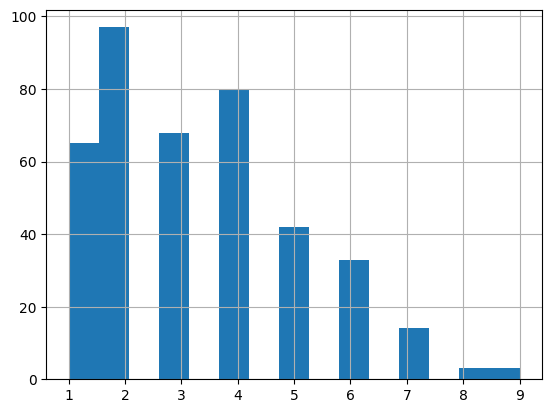

In [7]:
seq_len = [len(i.split()) for i in df['Pattern']]
pd.Series(seq_len).hist(bins = 15)
max_seq_len=10

/tmp/ipykernel_5240/3671009547.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)


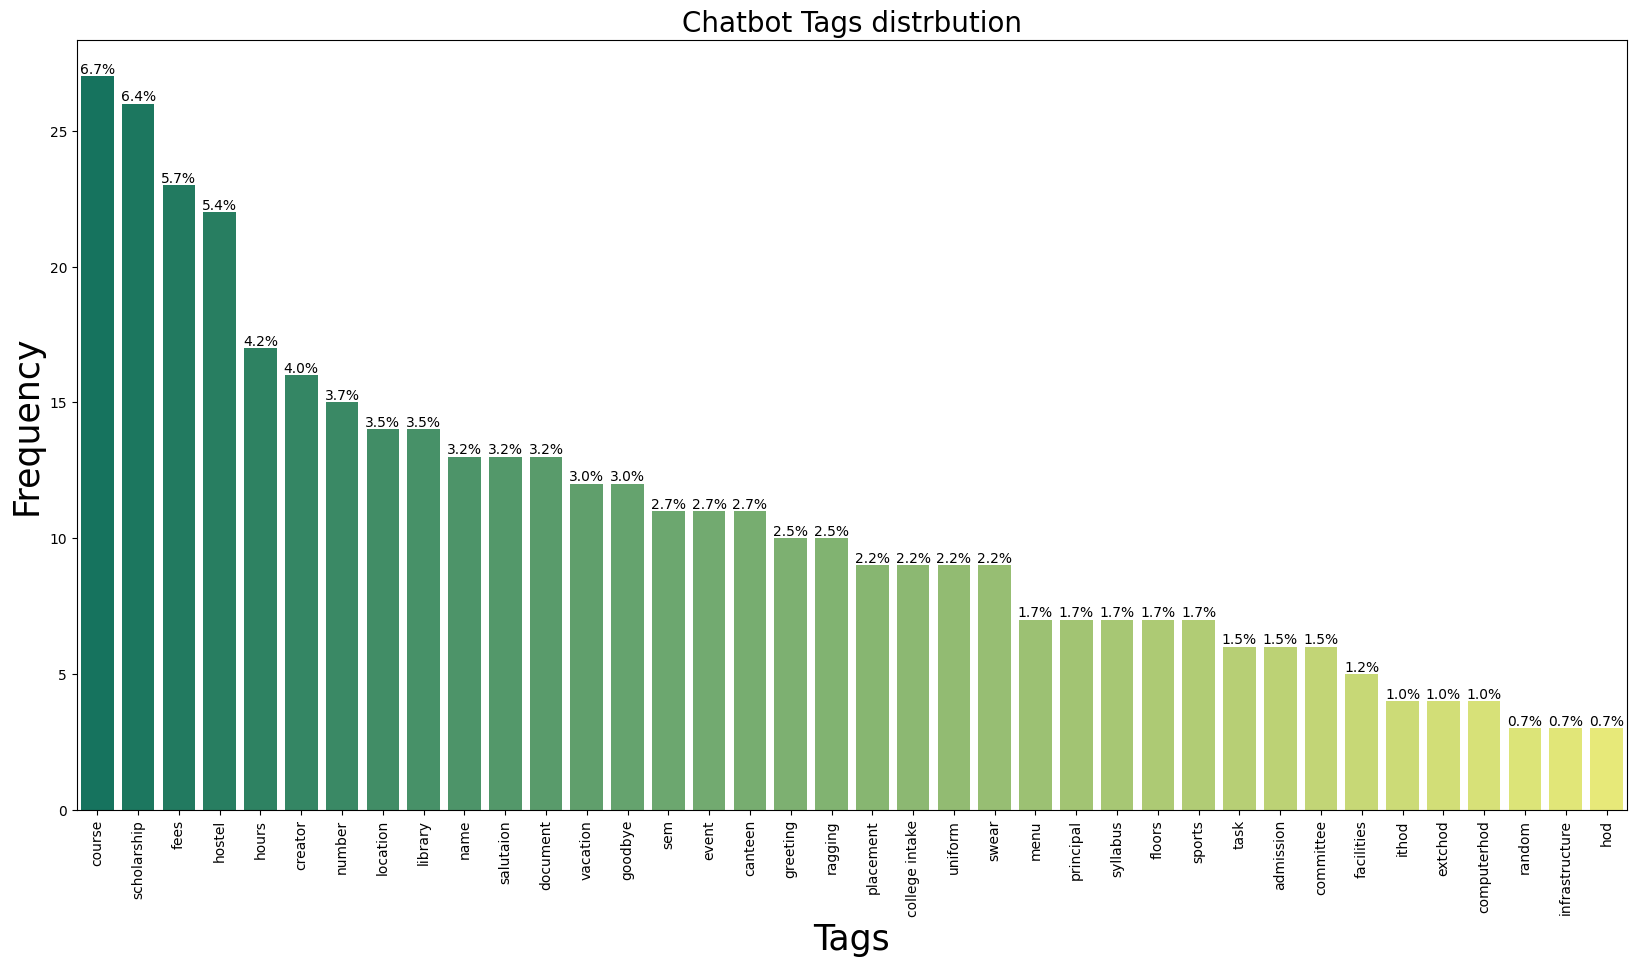

In [8]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()



    sns.set(font_scale = 1.2)
order = df['Tags'].value_counts().index
count_plot(df['Tags'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [9]:
train_text, train_labels = df['Pattern'], df['Tags']


In [10]:
model_name='distilbert-base-uncased'
tokenizer=DistilBertTokenizer.from_pretrained(model_name)
bert=DistilBertModel.from_pretrained(model_name)

In [11]:
tokens_train=tokenizer(
    train_text.to_list(),
    max_length=max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/home/syed227/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
tokens_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
tokens_train.get('input_ids')

[[101, 7632, 102, 0, 0, 0, 0, 0, 0, 0],
 [101, 2129, 2024, 2017, 1029, 102, 0, 0, 0, 0],
 [101, 2003, 3087, 2045, 1029, 102, 0, 0, 0, 0],
 [101, 7592, 102, 0, 0, 0, 0, 0, 0, 0],
 [101, 2204, 2154, 102, 0, 0, 0, 0, 0, 0],
 [101, 2054, 1005, 1055, 2039, 102, 0, 0, 0, 0],
 [101, 2129, 2024, 8038, 102, 0, 0, 0, 0, 0],
 [101, 4931, 2100, 102, 0, 0, 0, 0, 0, 0],
 [101, 2054, 6342, 2361, 102, 0, 0, 0, 0, 0],
 [101, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 102],
 [101, 22330, 2050, 102, 0, 0, 0, 0, 0, 0],
 [101, 2156, 2017, 102, 0, 0, 0, 0, 0, 0],
 [101, 9061, 9061, 102, 0, 0, 0, 0, 0, 0],
 [101, 2156, 2017, 2101, 102, 0, 0, 0, 0, 0],
 [101, 9119, 102, 0, 0, 0, 0, 0, 0, 0],
 [101, 1045, 2572, 2975, 102, 0, 0, 0, 0, 0],
 [101, 9061, 102, 0, 0, 0, 0, 0, 0, 0],
 [101, 2031, 1037, 2204, 2154, 102, 0, 0, 0, 0],
 [101, 2831, 2000, 2017, 2101, 102, 0, 0, 0, 0],
 [101, 23746, 8516, 102, 0, 0, 0, 0, 0, 0],
 [101, 1045, 2288, 2000, 2175, 102, 0, 0, 0, 0],
 [101, 14181, 2290, 102, 0, 0, 0, 0, 0, 0

In [14]:
tokens_train.get('attention_mask')

[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
 [1, 1, 1,

In [15]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask=torch.tensor(tokens_train['attention_mask'])

In [16]:
le=LabelEncoder()
train_labels=le.fit_transform(train_labels)


In [17]:
train_y=torch.tensor(train_labels.tolist())

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size=16
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


In [19]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert=bert
        self.dropout=nn.Dropout(0.2)

        self.relu=nn.ReLU()

        self.fc1=nn.Linear(768, 512)
        self.fc2=nn.Linear(512, 256)
        self.fc3=nn.Linear(256,output_dim)

        self.softmax=nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        cls_hs=self.bert(sent_id, attention_mask=mask)[0][:,0]
        x=self.fc1(cls_hs)
        x=self.relu(x)
        x=self.dropout(x)

        x=self.fc2(x)
        x=self.relu(x)
        x=self.dropout(x)

        x=self.fc3(x)

        x=self.softmax(x)

        return x



In [20]:
for param in bert.parameters():
      param.requires_grad = False
model = BERT(bert)

summary(model)

Layer (type:depth-idx)                                  Param #
BERT                                                    --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           9,766
├─LogSoftmax: 1-7                                       --
Total 

In [21]:
optimizer = AdamW(model.parameters(), lr = 1e-3)

/home/syed227/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
class_wts = compute_class_weight(class_weight='balanced',classes= np.unique(train_labels), y=train_labels)
print(class_wts)

[1.77631579 0.96889952 1.18421053 1.77631579 2.66447368 0.39473684
 0.66611842 0.81983806 0.96889952 2.66447368 2.13157895 0.46338673
 1.52255639 0.88815789 1.06578947 3.55263158 0.48444976 0.62693498
 3.55263158 2.66447368 0.7612782  0.7612782  1.52255639 0.81983806
 0.71052632 1.18421053 1.52255639 1.06578947 3.55263158 0.81983806
 0.40991903 0.96889952 1.52255639 1.18421053 1.52255639 1.77631579
 1.18421053 0.88815789]


In [23]:
weights= torch.tensor(class_wts,dtype=torch.float)
# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [24]:
train_losses=[]
# number of training epochs
epochs = 250

In [25]:
def train():
  
  model.train()
  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # clear calculated gradients
    optimizer.zero_grad()
  
    # We are not using learning rate scheduler as of now
    # lr_sch.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [26]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 250

 Epoch 2 / 250

 Epoch 3 / 250

 Epoch 4 / 250

 Epoch 5 / 250

 Epoch 6 / 250

 Epoch 7 / 250

 Epoch 8 / 250

 Epoch 9 / 250

 Epoch 10 / 250

 Epoch 11 / 250

 Epoch 12 / 250

 Epoch 13 / 250

 Epoch 14 / 250

 Epoch 15 / 250

 Epoch 16 / 250

 Epoch 17 / 250

 Epoch 18 / 250

 Epoch 19 / 250

 Epoch 20 / 250

 Epoch 21 / 250

 Epoch 22 / 250

 Epoch 23 / 250

 Epoch 24 / 250

 Epoch 25 / 250

 Epoch 26 / 250

 Epoch 27 / 250

 Epoch 28 / 250

 Epoch 29 / 250

 Epoch 30 / 250

 Epoch 31 / 250

 Epoch 32 / 250

 Epoch 33 / 250

 Epoch 34 / 250

 Epoch 35 / 250

 Epoch 36 / 250

 Epoch 37 / 250

 Epoch 38 / 250

 Epoch 39 / 250

 Epoch 40 / 250

 Epoch 41 / 250

 Epoch 42 / 250

 Epoch 43 / 250

 Epoch 44 / 250

 Epoch 45 / 250

 Epoch 46 / 250

 Epoch 47 / 250

 Epoch 48 / 250

 Epoch 49 / 250

 Epoch 50 / 250

 Epoch 51 / 250

 Epoch 52 / 250

 Epoch 53 / 250

 Epoch 54 / 250

 Epoch 55 / 250

 Epoch 56 / 250

 Epoch 57 / 250

 Epoch 58 / 250

 Epoch 59 / 250

 Epoc

In [27]:
def get_prediction(str):
    test_text = [str]
    model.eval()
 
    tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    padding='longest',
    truncation=True,
    return_token_type_ids=False
    )
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])
    
    preds = None
    with torch.no_grad():
        preds = model(test_seq.to(device), test_mask.to(device))
    
    preds = preds.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    print("Intent Identified: ", le.inverse_transform(preds)[0])
    return le.inverse_transform(preds)[0]


def get_response(message): 
    intent = get_prediction(message)
    for i in data['intents']: 
        if i["tag"] == intent:
            result = random.choice(i["responses"])
            break
    print(f"Response : {result}")
    return "Intent: "+ intent + '\n' + "Response: " + result

In [29]:
get_response("Hi")

Intent Identified:  greeting
Response : Hi there, how can I help?


'Intent: greeting\nResponse: Hi there, how can I help?'